# Sensor Choice
## The main purpose of this notebook is to experiment with including back angle and/or derivatives of all included angles

In [101]:
# Import required libraries
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Model, load_model
import seaborn as sns
import datetime

import os.path

from importlib import reload

from utils import *
from autoencoder import AutoEncoder

In [102]:
%reload_ext autoreload
# %aimport utils
# %aimport autoencoder
%autoreload 2

In [4]:
# Import preprocessed data
file_path = '/Users/jamesmeyer/University of Bath/Patient Simulator FYP - General/datasets/'
DIAGRAM_FILE_PATH = '/Users/jamesmeyer/University of Bath/Patient Simulator FYP - General/diagrams/'

In [15]:
### Set constant
seq_size = 20

## Just left and right

In [6]:
sensors = ['left_angle', 'right_angle'] #'back_angle', 
no_feats = len(sensors)

In [7]:
file_version = f'ws20num{no_feats}derFalse'
file_name = f'{file_version}-control.npy'
path = file_path + file_name
trainX = np.load(path)
print(f'Number of control training samples: {trainX.shape}')

Number of control training samples: (12022, 20, 2)


In [8]:
# Load just the patient data
file_patient = f'{file_version}-patient-shaved.npy'
path = file_path + file_patient
patientX = np.load(path)
print(f'Number of patient testing samples: {patientX.shape}')

Number of patient testing samples: (38167, 20, 2)


In [9]:
# Retrieve data and place with pd dataframe
patient_file_path = '/Users/jamesmeyer/University of Bath/Patient Simulator FYP - General/datasets/patient/patient_data.csv'
dataframe = pd.read_csv(patient_file_path, parse_dates=['datetime'])
df = dataframe.loc[:,sensors]
df.loc[:,'Date'] = pd.to_datetime(dataframe.loc[:,'datetime'])

# Split test and train data
train, test = df.loc[df['Date'] <= '2011-12-01 11:38:00'], df.loc[df['Date'] > '2011-12-01 11:38:00']
train

left_angle  right_angle                    Date
0        0.572584     0.215395 2011-12-01 11:04:05.000
1        0.568733     0.200416 2011-12-01 11:04:05.050
2        0.564883     0.200416 2011-12-01 11:04:05.100
3        0.557181     0.201110 2011-12-01 11:04:05.150
4        0.541779     0.200416 2011-12-01 11:04:05.200
...           ...          ...                     ...
38182    0.276088     0.527046 2011-12-01 11:35:54.100
38183    0.276088     0.525659 2011-12-01 11:35:54.150
38184    0.276088     0.524272 2011-12-01 11:35:54.200
38185    0.276088     0.524272 2011-12-01 11:35:54.250
38186    0.276088     0.524272 2011-12-01 11:35:54.300

[38187 rows x 3 columns]

In [19]:
compress = 0.4
units_one = int(trainX.shape[1] * trainX.shape[2] * compress)
units_two = int(units_one * 0.5)
print(f"1st layer units: {units_one}, 2nd layer units: {units_two}")

1st layer units: 16, 2nd layer units: 8


In [20]:
twen_time_code = '16300_0421'
twen_model_file = f'{twen_time_code}-model.h5'
twen_model_file

'16300_0421-model.h5'

In [21]:
# Fit the model
callback = EarlyStopping(monitor='loss', patience=2, min_delta=1e-3)
WZ_twenty = AutoEncoder(units_one, units_two, trainX, twen_model_file, callback, DIAGRAM_FILE_PATH)

Checking for 16300_0421-model.h5

Model loaded from: 16300_0421-model.h5
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_52 (LSTM)               (None, 20, 16)            1216      
_________________________________________________________________
dropout_26 (Dropout)         (None, 20, 16)            0         
_________________________________________________________________
lstm_53 (LSTM)               (None, 8)                 800       
_________________________________________________________________
repeat_vector_13 (RepeatVect (None, 20, 8)             0         
_________________________________________________________________
lstm_54 (LSTM)               (None, 20, 8)             544       
_________________________________________________________________
lstm_55 (LSTM)               (None, 20, 16)            1600      
______________________________________________

In [22]:
patientPredict = WZ_twenty.model.predict(patientX)

<module 'matplotlib.pyplot' from '/Users/jamesmeyer/.pyenv/versions/fyp-env/lib/python3.9/site-packages/matplotlib/pyplot.py'>

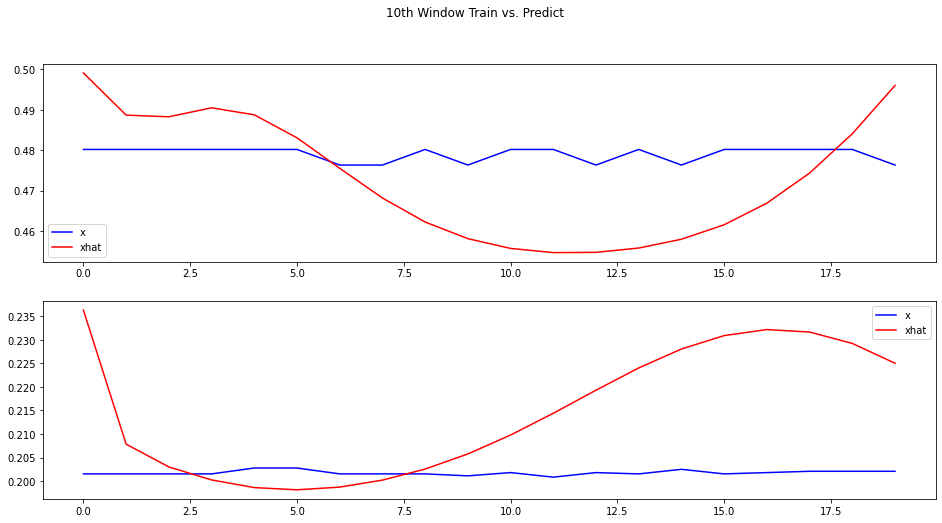

In [23]:
example = 10
example_plot(example, no_feats, seq_size, patientX, patientPredict)

In [24]:
area_error = error_computation(patientX, patientPredict, 'Area')
area_error.shape

(38167, 2)

Saved as: /Users/jamesmeyer/University of Bath/Patient Simulator FYP - General/diagrams/error-hist-Area-16300_0421-model.h5-3.png


<module 'matplotlib.pyplot' from '/Users/jamesmeyer/.pyenv/versions/fyp-env/lib/python3.9/site-packages/matplotlib/pyplot.py'>

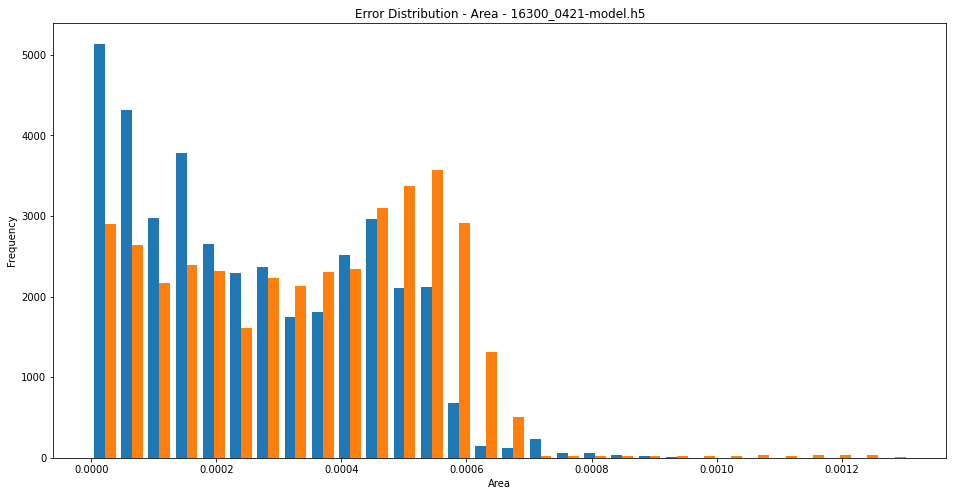

In [25]:
error_hist_and_save(area_error, 'Area', twen_model_file, DIAGRAM_FILE_PATH)

In [26]:
pct = 0.8
thresh = fixed_thresh(pct, area_error, len(train[seq_size:]))
thresh

array([0.00104509, 0.00104509, 0.00104509, ..., 0.00104509, 0.00104509,
       0.00104509])

In [27]:
anomaly_frame = anomaly_df(train, seq_size, area_error, thresh)
anomaly_frame.head()

left_angle  right_angle                    Date     error    thresh  \
20    0.480169     0.201803 2011-12-01 11:04:06.000  0.000262  0.001045   
21    0.480169     0.200832 2011-12-01 11:04:06.050  0.000263  0.001045   
22    0.476319     0.201803 2011-12-01 11:04:06.100  0.000268  0.001045   
23    0.480169     0.201526 2011-12-01 11:04:06.150  0.000275  0.001045   
24    0.476319     0.202497 2011-12-01 11:04:06.200  0.000281  0.001045   

    anomaly  
20    False  
21    False  
22    False  
23    False  
24    False

Saved as: /Users/jamesmeyer/University of Bath/Patient Simulator FYP - General/diagrams/error-thresh-0.8-Area-16300_0421-model.h5-1.png


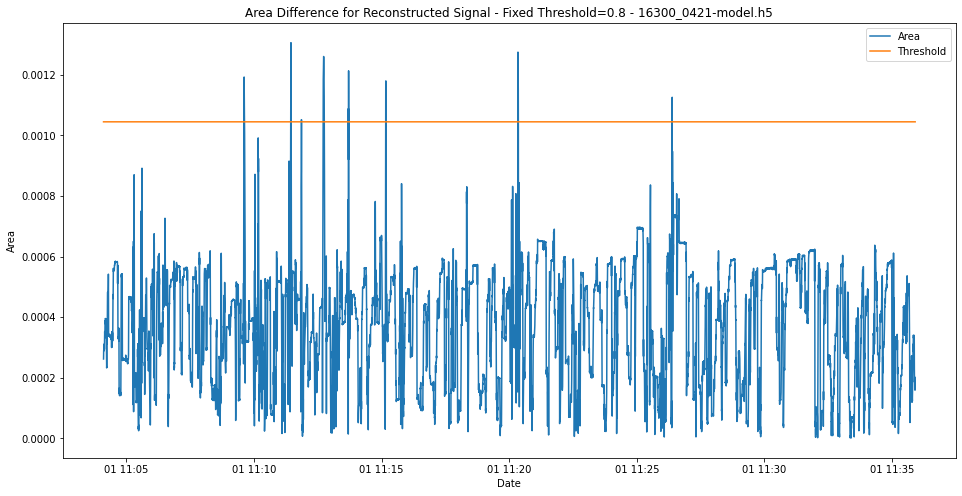

In [28]:
anomalies, _ = error_vs_thresh_plot_and_save(anomaly_frame, pct, 'Area', twen_model_file, DIAGRAM_FILE_PATH)

Saved as: /Users/jamesmeyer/University of Bath/Patient Simulator FYP - General/diagrams/detected-anomalies-0.8-Area-16300_0421-model.h5-1.png


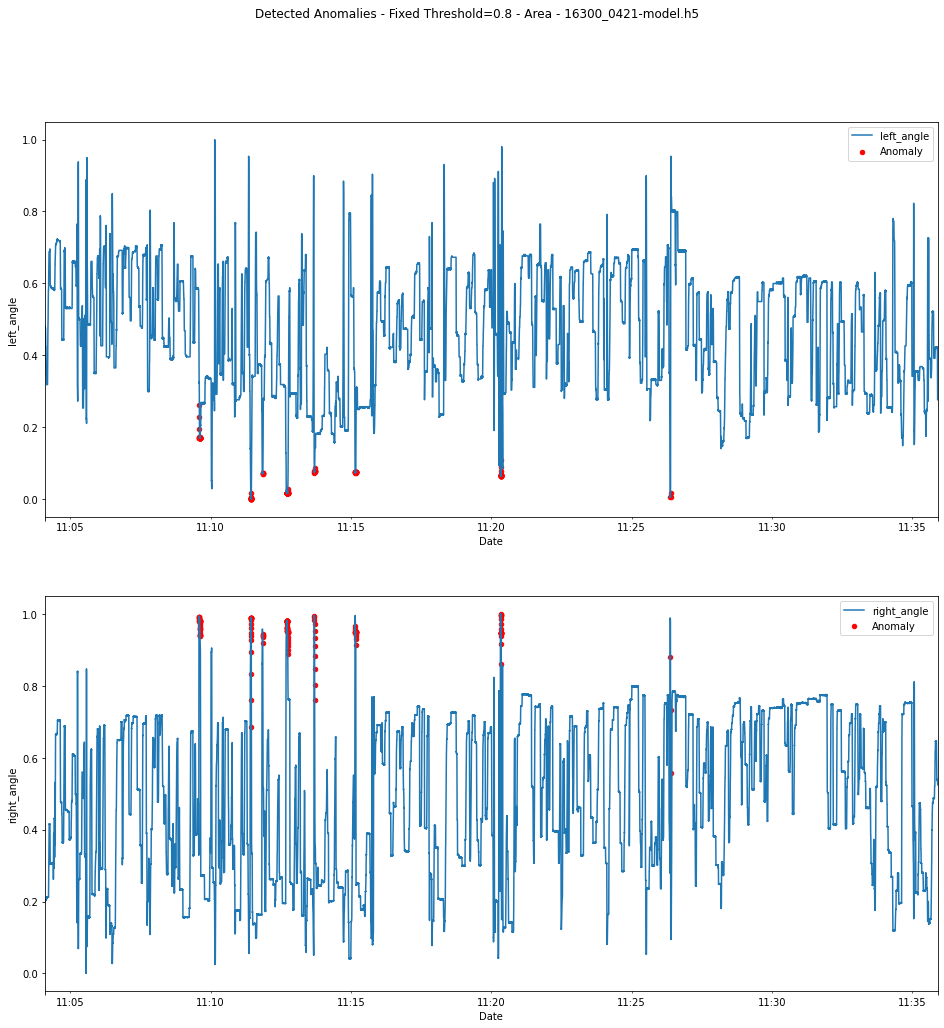

In [29]:
detect_anom_plot_and_save(no_feats, sensors, anomaly_frame, anomalies, pct, 'Area', twen_model_file, DIAGRAM_FILE_PATH)

## Left, right and back

In [74]:
sensors = ['back_angle', 'left_angle', 'right_angle'] 
no_feats = len(sensors)

In [75]:
file_version = f'ws20num{no_feats}derFalse'
file_name = f'{file_version}-control.npy'
path = file_path + file_name
trainX = np.load(path)
print(f'Number of control training samples: {trainX.shape}')

Number of control training samples: (12022, 20, 3)


In [76]:
# Load just the patient data
file_patient = f'{file_version}-patient-shaved.npy'
path = file_path + file_patient
patientX = np.load(path)
print(f'Number of patient testing samples: {patientX.shape}')

Number of patient testing samples: (38167, 20, 3)


In [77]:
# Retrieve data and place with pd dataframe
patient_file_path = '/Users/jamesmeyer/University of Bath/Patient Simulator FYP - General/datasets/patient/patient_data.csv'
dataframe = pd.read_csv(patient_file_path, parse_dates=['datetime'])
df = dataframe.loc[:,sensors]
df.loc[:,'Date'] = pd.to_datetime(dataframe.loc[:,'datetime'])

# Split test and train data
train, test = df.loc[df['Date'] <= '2011-12-01 11:38:00'], df.loc[df['Date'] > '2011-12-01 11:38:00']
train

back_angle  left_angle  right_angle                    Date
0        0.424307    0.572584     0.215395 2011-12-01 11:04:05.000
1        0.456290    0.568733     0.200416 2011-12-01 11:04:05.050
2        0.488273    0.564883     0.200416 2011-12-01 11:04:05.100
3        0.530917    0.557181     0.201110 2011-12-01 11:04:05.150
4        0.573561    0.541779     0.200416 2011-12-01 11:04:05.200
...           ...         ...          ...                     ...
38182    0.626866    0.276088     0.527046 2011-12-01 11:35:54.100
38183    0.626866    0.276088     0.525659 2011-12-01 11:35:54.150
38184    0.616205    0.276088     0.524272 2011-12-01 11:35:54.200
38185    0.616205    0.276088     0.524272 2011-12-01 11:35:54.250
38186    0.616205    0.276088     0.524272 2011-12-01 11:35:54.300

[38187 rows x 4 columns]

In [35]:
compress = 0.4
units_one = int(trainX.shape[1] * trainX.shape[2] * compress)
units_two = int(units_one * 0.5)
print(f"1st layer units: {units_one}, 2nd layer units: {units_two}")

1st layer units: 24, 2nd layer units: 12


In [36]:
backin_time_code = '160000_0422'
backin_model_file = f'{backin_time_code}-model.h5'
backin_model_file

'160000_0422-model.h5'

Checking for 160000_0422-model.h5

Double layer model built
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 24)            2688      
_________________________________________________________________
dropout (Dropout)            (None, 20, 24)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 12)                1776      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 20, 12)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 20, 12)            1200      
_________________________________________________________________
lstm_3 (LSTM)                (None, 20, 24)            3552      
______________________________________________________________

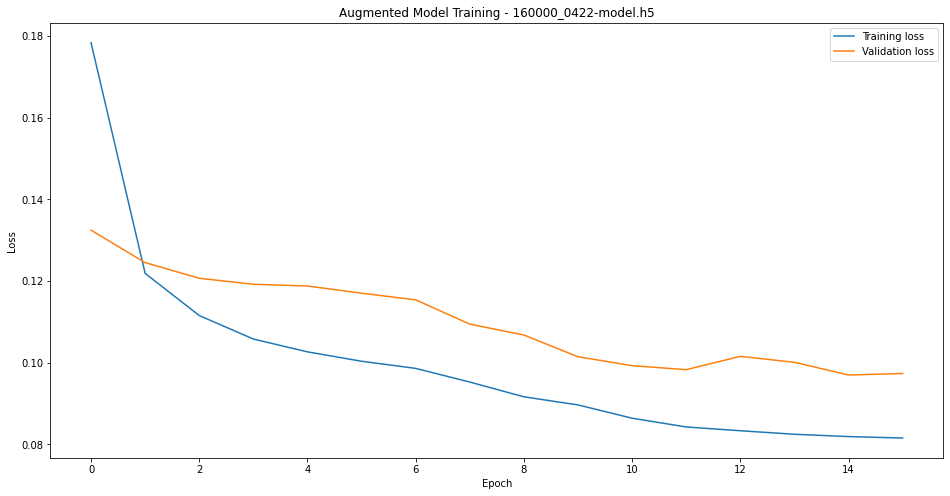

In [37]:
d

In [38]:
patientPredict = WZ_backin.model.predict(patientX)

<module 'matplotlib.pyplot' from '/Users/jamesmeyer/.pyenv/versions/fyp-env/lib/python3.9/site-packages/matplotlib/pyplot.py'>

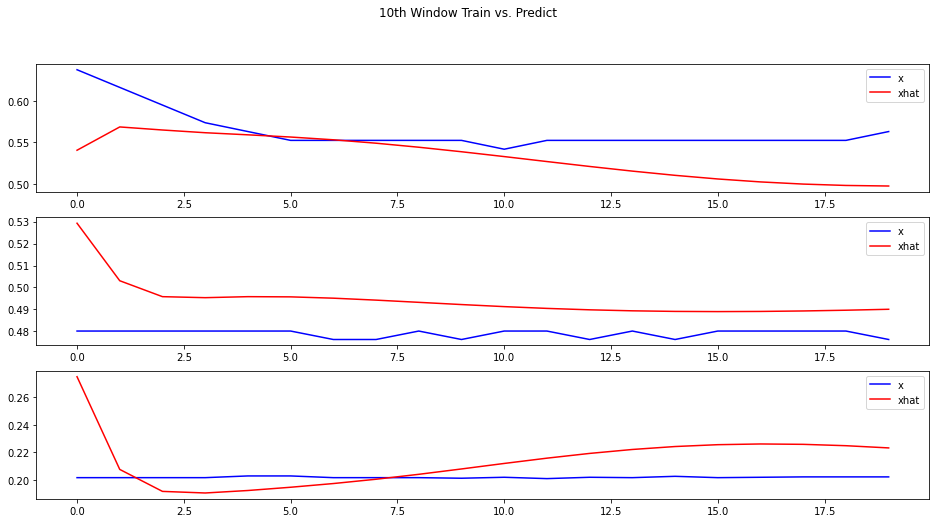

In [39]:
example = 10
example_plot(example, no_feats, seq_size, patientX, patientPredict)

In [40]:
area_error = error_computation(patientX, patientPredict, 'Area')
area_error.shape

(38167, 3)

Saved as: /Users/jamesmeyer/University of Bath/Patient Simulator FYP - General/diagrams/error-hist-Area-160000_0422-model.h5.png


<module 'matplotlib.pyplot' from '/Users/jamesmeyer/.pyenv/versions/fyp-env/lib/python3.9/site-packages/matplotlib/pyplot.py'>

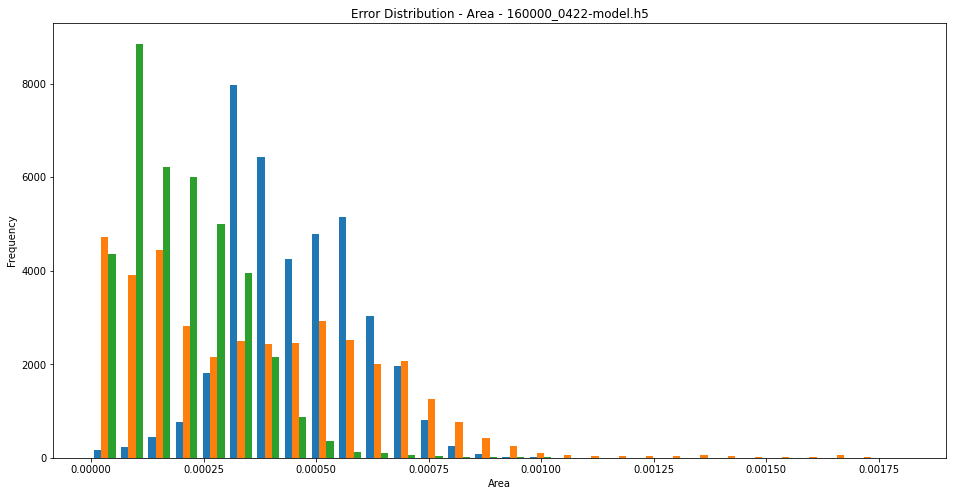

In [41]:
error_hist_and_save(area_error, 'Area', backin_model_file, DIAGRAM_FILE_PATH)

In [42]:
pct = 0.8
thresh = fixed_thresh(pct, area_error, len(train[seq_size:]))
thresh

array([0.00145291, 0.00145291, 0.00145291, ..., 0.00145291, 0.00145291,
       0.00145291])

In [43]:
anomaly_frame = anomaly_df(train, seq_size, area_error, thresh)
anomaly_frame.head()

back_angle  left_angle  right_angle                    Date     error  \
20    0.541578    0.480169     0.201803 2011-12-01 11:04:06.000  0.000486   
21    0.552239    0.480169     0.200832 2011-12-01 11:04:06.050  0.000560   
22    0.552239    0.476319     0.201803 2011-12-01 11:04:06.100  0.000624   
23    0.552239    0.480169     0.201526 2011-12-01 11:04:06.150  0.000677   
24    0.552239    0.476319     0.202497 2011-12-01 11:04:06.200  0.000711   

      thresh  anomaly  
20  0.001453    False  
21  0.001453    False  
22  0.001453    False  
23  0.001453    False  
24  0.001453    False

Saved as: /Users/jamesmeyer/University of Bath/Patient Simulator FYP - General/diagrams/error-thresh-0.8-Area-160000_0422-model.h5.png


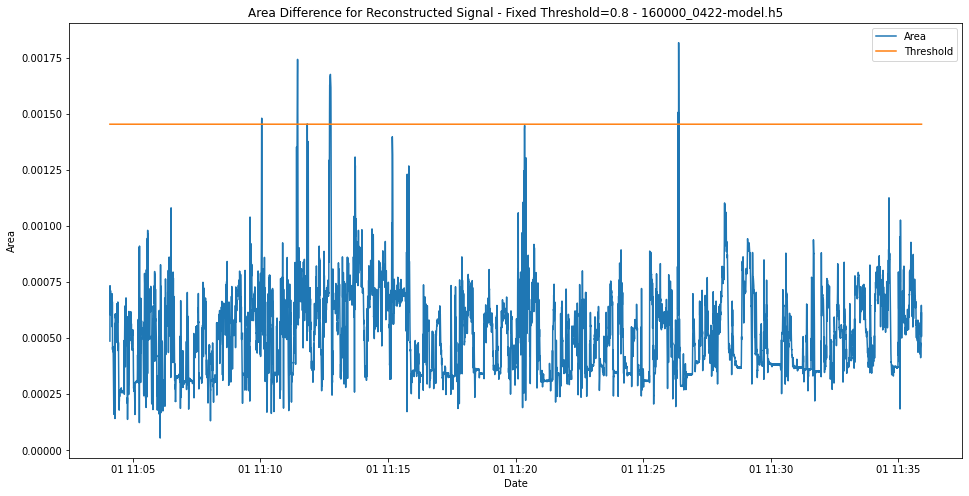

In [44]:
anomalies, _ = error_vs_thresh_plot_and_save(anomaly_frame, pct, 'Area', backin_model_file, DIAGRAM_FILE_PATH)

Saved as: /Users/jamesmeyer/University of Bath/Patient Simulator FYP - General/diagrams/detected-anomalies-0.8-Area-160000_0422-model.h5.png


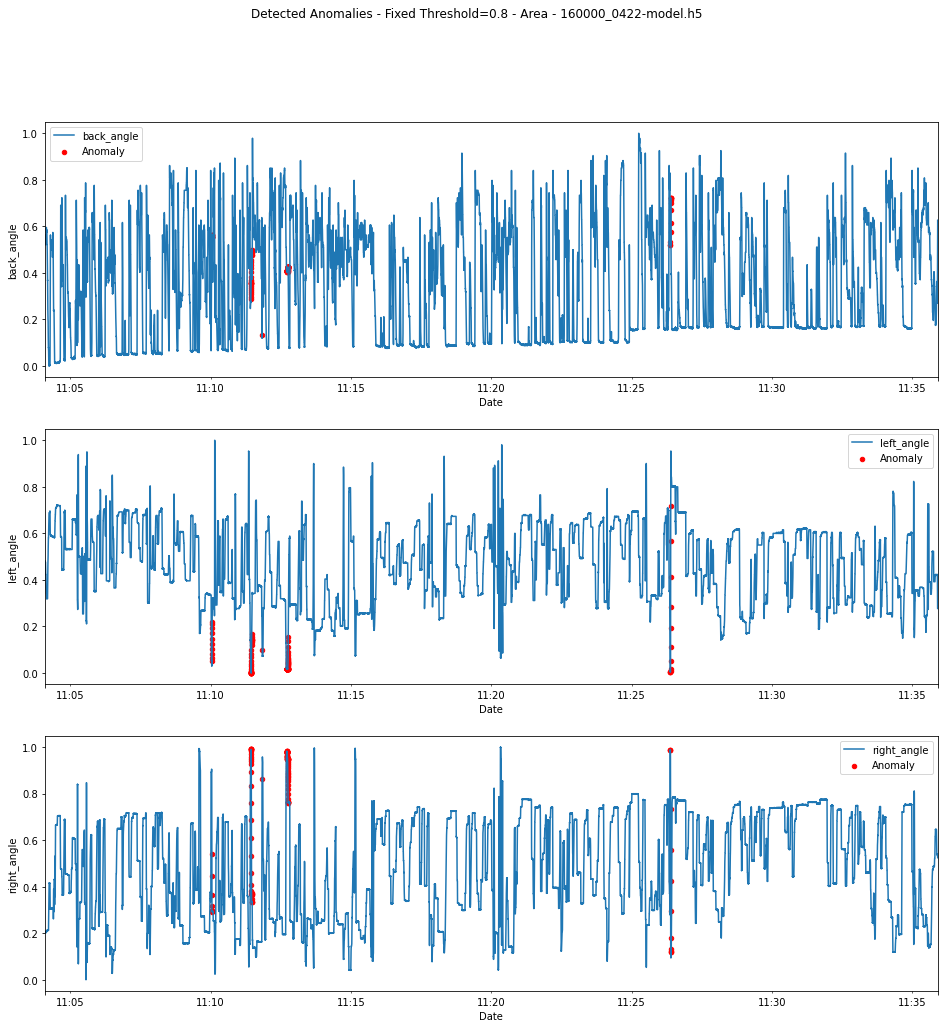

In [45]:
detect_anom_plot_and_save(no_feats, sensors, anomaly_frame, anomalies, pct, 'Area', backin_model_file, DIAGRAM_FILE_PATH)

## Left, right and back + slightly larger initial layer 0.4 -> 0.5

In [72]:
compress = 0.5
units_one = int(trainX.shape[1] * trainX.shape[2] * compress)
units_two = int(units_one * 0.5)
print(f"1st layer units: {units_one}, 2nd layer units: {units_two}")

1st layer units: 30, 2nd layer units: 15


In [73]:
backintwo_time_code = '162000_0422'
backintwo_model_file = f'{backintwo_time_code}-model.h5'
backintwo_model_file

'162000_0422-model.h5'

Checking for 162000_0422-model.h5

Double layer model built
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 20, 30)            4080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 30)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 15)                2760      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 20, 15)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 20, 15)            1860      
_________________________________________________________________
lstm_7 (LSTM)                (None, 20, 30)            5520      
____________________________________________________________

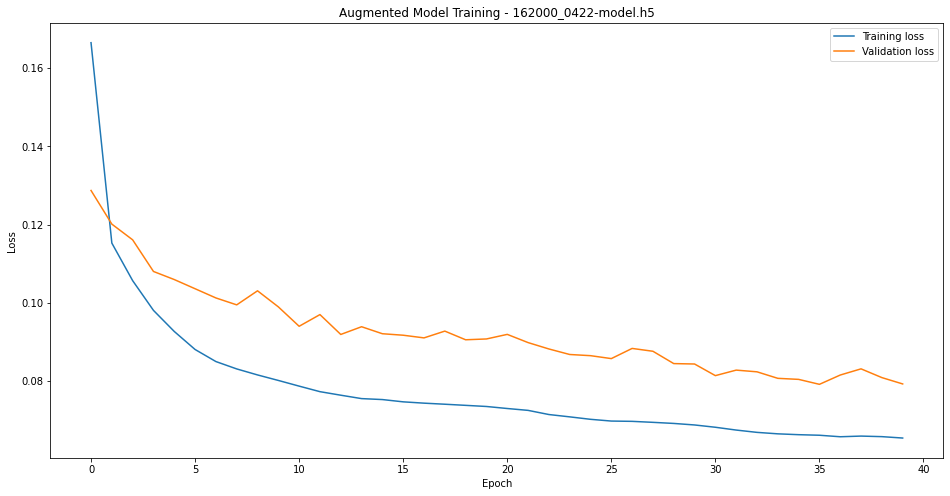

In [50]:
# Fit the model
callback = EarlyStopping(monitor='loss', patience=3, min_delta=1e-3)
backintwo = AutoEncoder(units_one, units_two, trainX, backintwo_model_file, callback, DIAGRAM_FILE_PATH)

In [87]:
patientPredict = backintwo.model.predict(patientX)

<module 'matplotlib.pyplot' from '/Users/jamesmeyer/.pyenv/versions/fyp-env/lib/python3.9/site-packages/matplotlib/pyplot.py'>

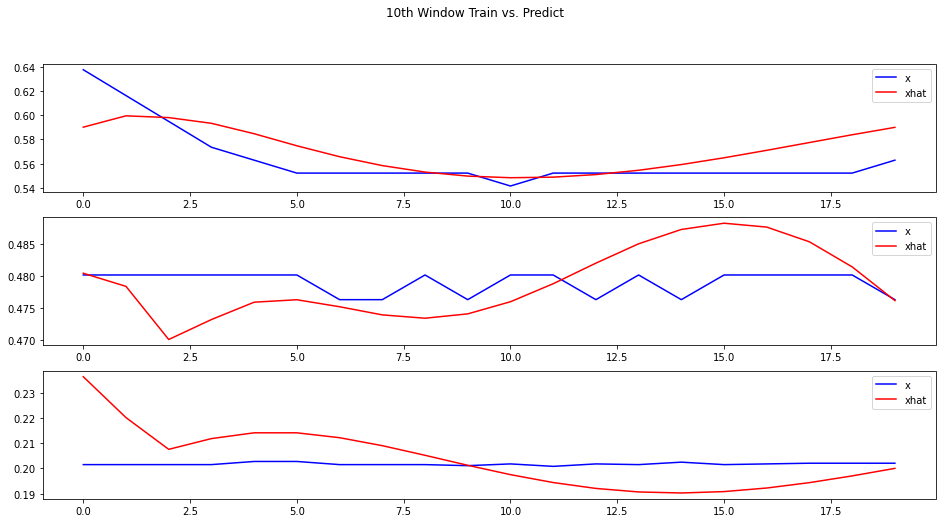

In [88]:
example = 10
example_plot(example, no_feats, seq_size, patientX, patientPredict)

In [89]:
area_error = error_computation(patientX, patientPredict, 'Area')
area_error.shape

(38167, 3)

Saved as: /Users/jamesmeyer/University of Bath/Patient Simulator FYP - General/diagrams/error-hist-Area-162000_0422-model.h5-1.png


<module 'matplotlib.pyplot' from '/Users/jamesmeyer/.pyenv/versions/fyp-env/lib/python3.9/site-packages/matplotlib/pyplot.py'>

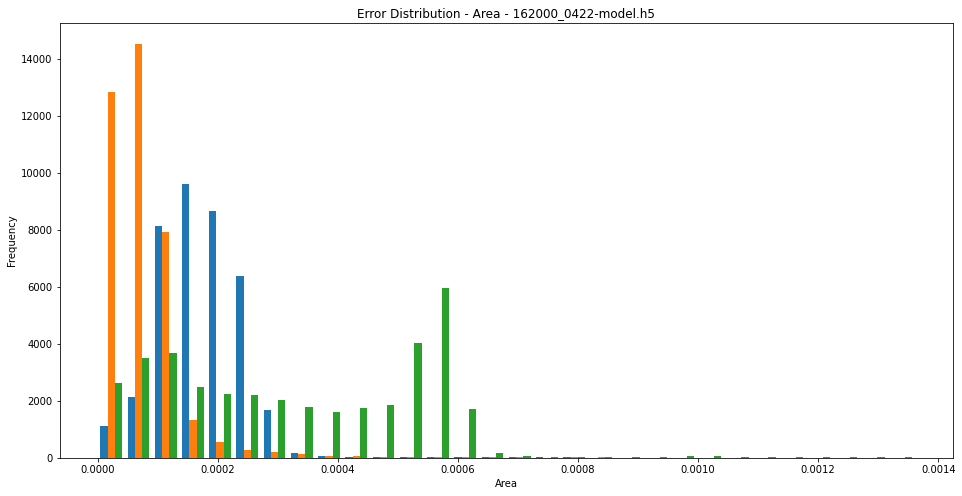

In [90]:
error_hist_and_save(area_error, 'Area', backintwo_model_file, DIAGRAM_FILE_PATH)

In [91]:
pct = 0.8
thresh = fixed_thresh(pct, area_error, len(train[seq_size:]))
thresh

array([0.00108842, 0.00108842, 0.00108842, ..., 0.00108842, 0.00108842,
       0.00108842])

In [110]:
%reload_ext autoreload
# %aimport utils
# %aimport autoencoder
%autoreload 2

In [92]:
trainPredict = backintwo.model.predict(trainX)

In [93]:
trainarea_error = error_computation(trainX, trainPredict, 'Area')
trainarea_error.shape

(12022, 3)

In [111]:
norm_dis_error, stats, anom_score = normal_dis_solver(trainX, trainPredict, 'Area')
stats

[{'mean': 0.00014700001561015105, 'std': 0.00018882157602227766},
 {'mean': 0.0001020597360966667, 'std': 0.00019207111834068592},
 {'mean': -0.00032650209129217597, 'std': 0.00032194301852695394}]

In [112]:
anom_score

array([[2.00513232e-04, 9.25303101e-04, 1.58914276e-03],
       [1.74237017e-04, 8.69965216e-04, 1.46321894e-03],
       [2.36900581e-04, 8.27860418e-04, 1.37978223e-03],
       ...,
       [9.99445345e-05, 5.66685244e-04, 7.48845789e-05],
       [1.82650746e-04, 3.32514265e-04, 4.58701089e-04],
       [2.23162937e-04, 2.58971903e-04, 6.23491020e-04]])

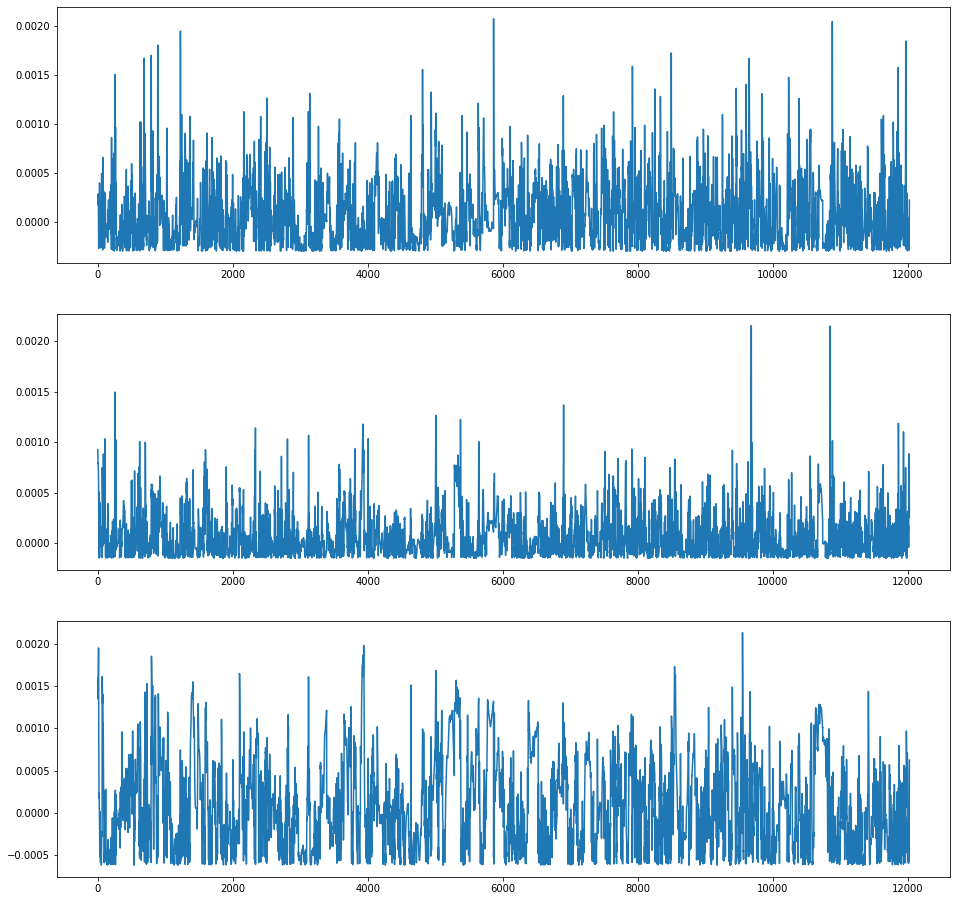

In [114]:
fig, axes = plt.subplots(no_feats, 1, figsize=(16, 16))
for x in range(anom_score.shape[1]):
    axes[x].plot(anom_score[:,x])

Saved as: /Users/jamesmeyer/University of Bath/Patient Simulator FYP - General/diagrams/error-hist-Area-162000_0422-model.h5-train_norm.png


<module 'matplotlib.pyplot' from '/Users/jamesmeyer/.pyenv/versions/fyp-env/lib/python3.9/site-packages/matplotlib/pyplot.py'>

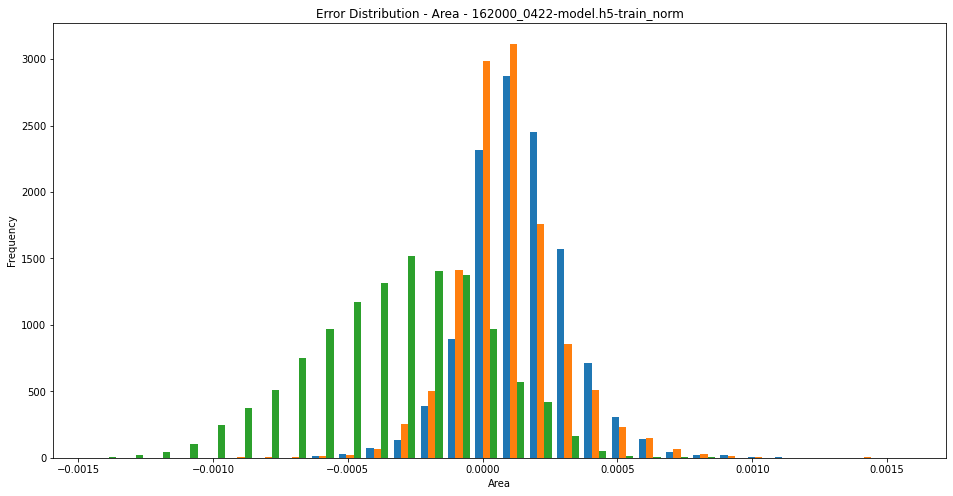

In [104]:
error_hist_and_save(norm_dis_error, 'Area', backintwo_model_file+'-train_norm', DIAGRAM_FILE_PATH)

In [95]:
train_pct = 0.8
train_thresh = fixed_thresh(train_pct, trainarea_error, len(train[seq_size:]))
train_thresh

array([0.00126323, 0.00126323, 0.00126323, ..., 0.00126323, 0.00126323,
       0.00126323])

In [56]:
anomaly_frame = anomaly_df(train, seq_size, area_error, thresh)
anomaly_frame.head()

back_angle  left_angle  right_angle                    Date     error  \
20    0.541578    0.480169     0.201803 2011-12-01 11:04:06.000  0.000138   
21    0.552239    0.480169     0.200832 2011-12-01 11:04:06.050  0.000136   
22    0.552239    0.476319     0.201803 2011-12-01 11:04:06.100  0.000143   
23    0.552239    0.480169     0.201526 2011-12-01 11:04:06.150  0.000150   
24    0.552239    0.476319     0.202497 2011-12-01 11:04:06.200  0.000160   

      thresh  anomaly  
20  0.001088    False  
21  0.001088    False  
22  0.001088    False  
23  0.001088    False  
24  0.001088    False

Saved as: /Users/jamesmeyer/University of Bath/Patient Simulator FYP - General/diagrams/error-thresh-0.8-Area-162000_0422-model.h5.png


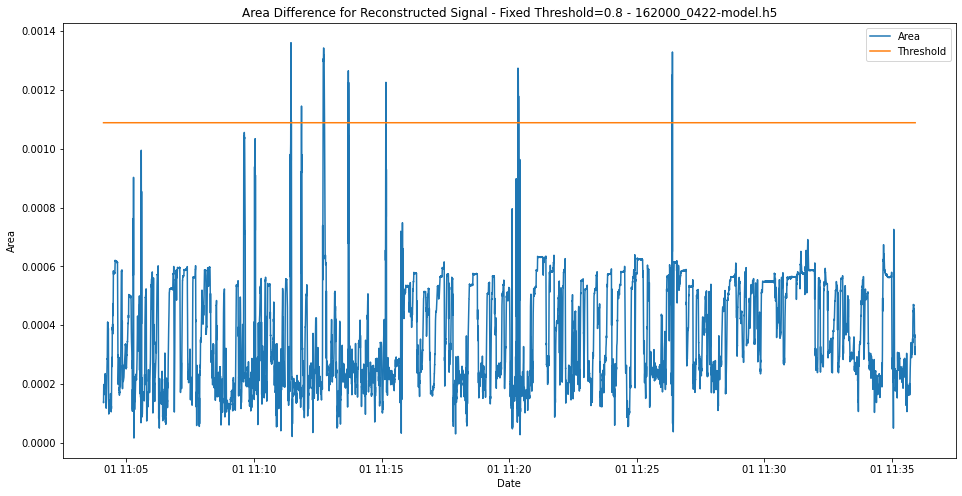

In [57]:
anomalies, _ = error_vs_thresh_plot_and_save(anomaly_frame, pct, 'Area', backintwo_model_file, DIAGRAM_FILE_PATH)

Saved as: /Users/jamesmeyer/University of Bath/Patient Simulator FYP - General/diagrams/detected-anomalies-0.8-Area-162000_0422-model.h5.png


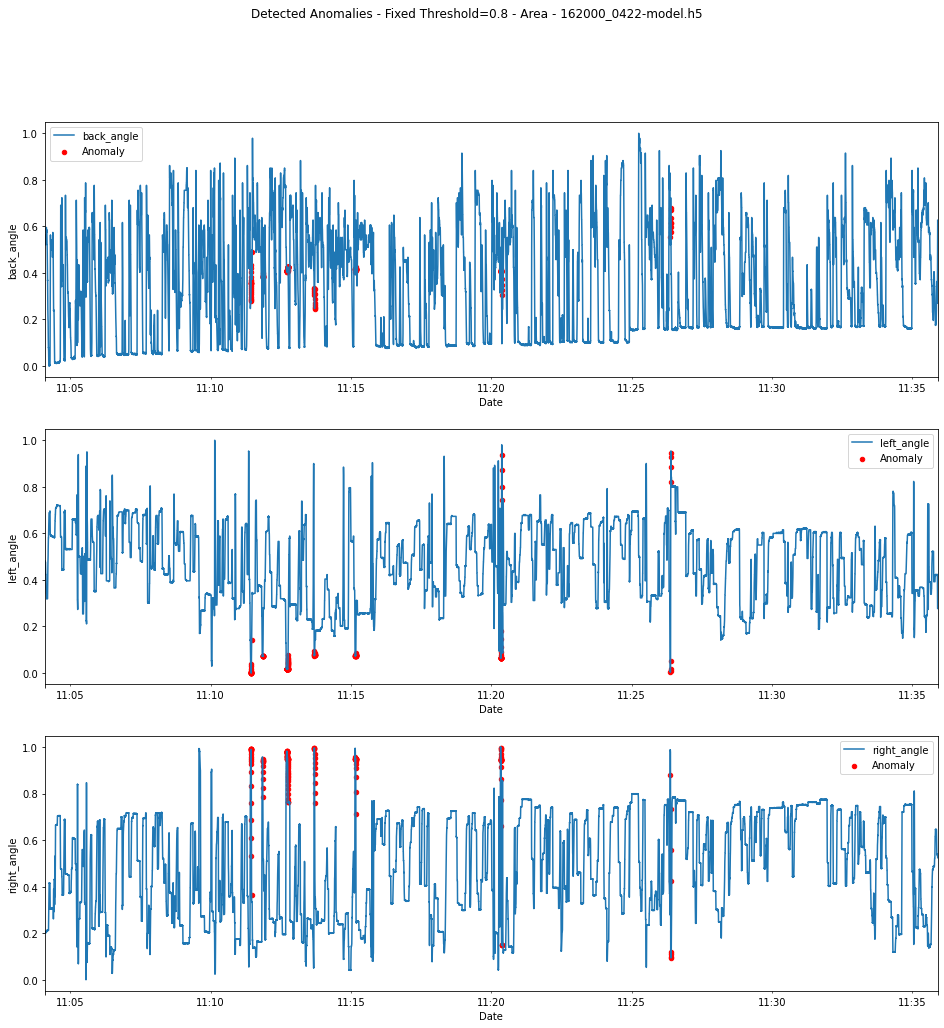

In [58]:
detect_anom_plot_and_save(no_feats, sensors, anomaly_frame, anomalies, pct, 'Area', backintwo_model_file, DIAGRAM_FILE_PATH)

## Same model type as directly above but trained with patient data.

In [59]:
# Load just the patient data
file_patient = f'{file_version}-patient-shaved.npy'
path = file_path + file_patient
trainX = np.load(path)
print(f'Number of patient testing samples: {trainX.shape}')

Number of patient testing samples: (38167, 20, 3)


In [61]:
compress = 0.5
units_one = int(trainX.shape[1] * trainX.shape[2] * compress)
units_two = int(units_one * 0.5)
print(f"1st layer units: {units_one}, 2nd layer units: {units_two}")

1st layer units: 30, 2nd layer units: 15


In [62]:
backpat_time_code = '164000_0422'
backpat_model_file = f'{backpat_time_code}-model.h5'
backpat_model_file

'164000_0422-model.h5'

Checking for 164000_0422-model.h5

Double layer model built
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 20, 30)            4080      
_________________________________________________________________
dropout_4 (Dropout)          (None, 20, 30)            0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 15)                2760      
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 20, 15)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 20, 15)            1860      
_________________________________________________________________
lstm_11 (LSTM)               (None, 20, 30)            5520      
____________________________________________________________

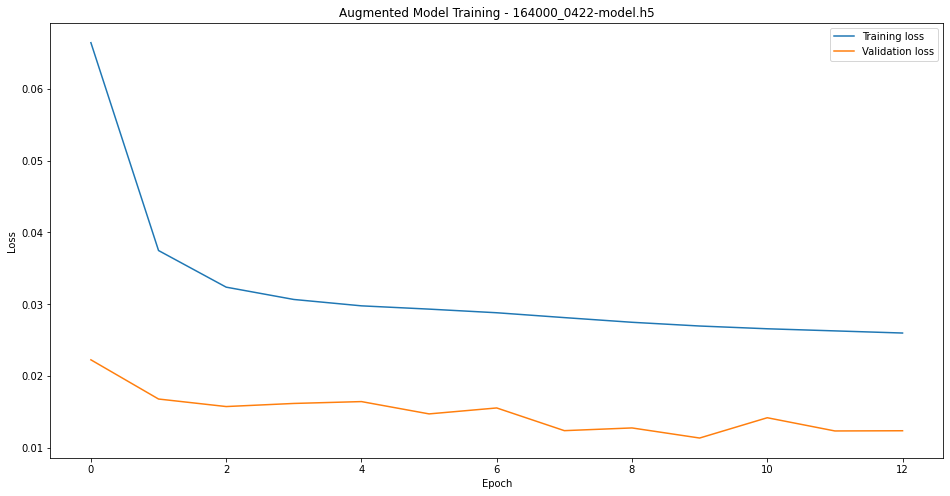

In [63]:
# Fit the model
callback = EarlyStopping(monitor='loss', patience=3, min_delta=1e-3)
backpat = AutoEncoder(units_one, units_two, trainX, backpat_model_file, callback, DIAGRAM_FILE_PATH)

In [64]:
patientPredict = backpat.model.predict(trainX)

<module 'matplotlib.pyplot' from '/Users/jamesmeyer/.pyenv/versions/fyp-env/lib/python3.9/site-packages/matplotlib/pyplot.py'>

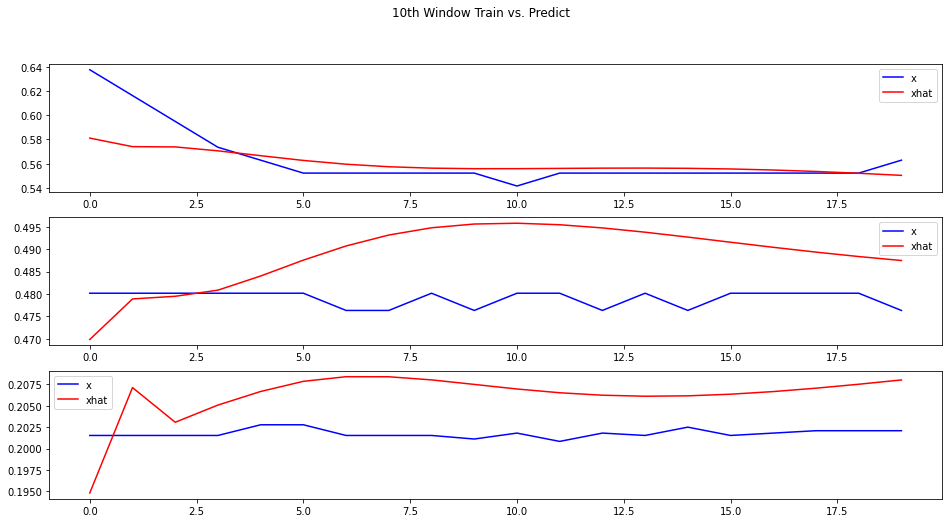

In [65]:
example = 10
example_plot(example, no_feats, seq_size, trainX, patientPredict)

In [66]:
area_error = error_computation(trainX, patientPredict, 'Area')
area_error.shape

(38167, 3)

Saved as: /Users/jamesmeyer/University of Bath/Patient Simulator FYP - General/diagrams/error-hist-Area-164000_0422-model.h5.png


<module 'matplotlib.pyplot' from '/Users/jamesmeyer/.pyenv/versions/fyp-env/lib/python3.9/site-packages/matplotlib/pyplot.py'>

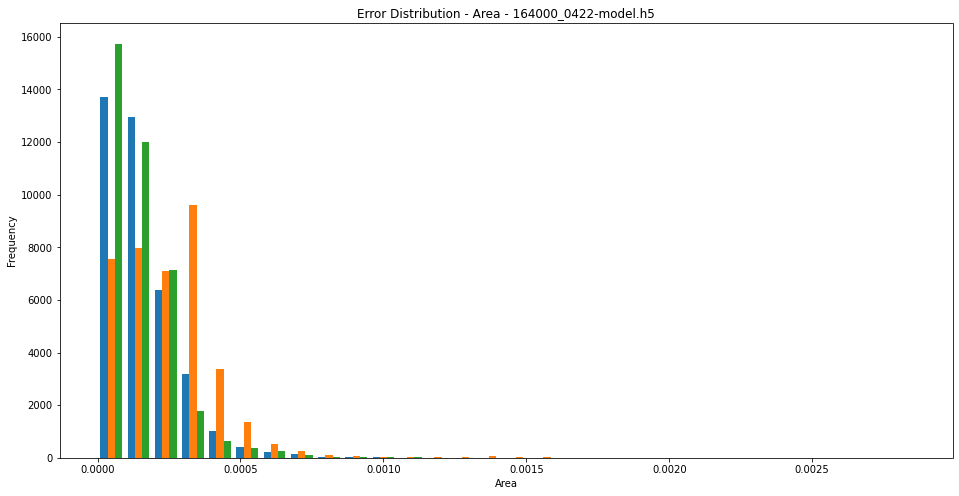

In [67]:
error_hist_and_save(area_error, 'Area', backpat_model_file, DIAGRAM_FILE_PATH)

In [68]:
pct = 0.8
thresh = fixed_thresh(pct, area_error, len(train[seq_size:]))
thresh

array([0.00228675, 0.00228675, 0.00228675, ..., 0.00228675, 0.00228675,
       0.00228675])

In [69]:
anomaly_frame = anomaly_df(train, seq_size, area_error, thresh)
anomaly_frame.head()

back_angle  left_angle  right_angle                    Date     error  \
20    0.541578    0.480169     0.201803 2011-12-01 11:04:06.000  0.000117   
21    0.552239    0.480169     0.200832 2011-12-01 11:04:06.050  0.000114   
22    0.552239    0.476319     0.201803 2011-12-01 11:04:06.100  0.000138   
23    0.552239    0.480169     0.201526 2011-12-01 11:04:06.150  0.000173   
24    0.552239    0.476319     0.202497 2011-12-01 11:04:06.200  0.000211   

      thresh  anomaly  
20  0.002287    False  
21  0.002287    False  
22  0.002287    False  
23  0.002287    False  
24  0.002287    False

Saved as: /Users/jamesmeyer/University of Bath/Patient Simulator FYP - General/diagrams/error-thresh-0.8-Area-164000_0422-model.h5.png


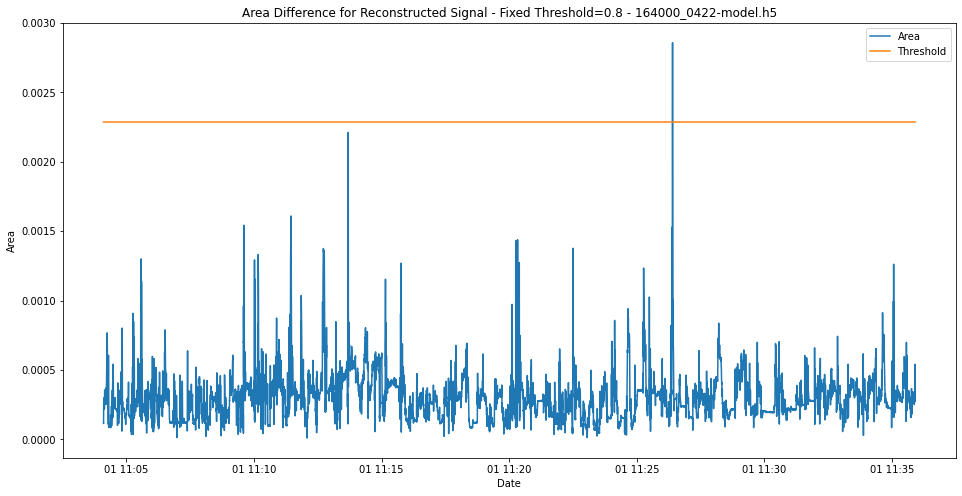

In [70]:
anomalies, _ = error_vs_thresh_plot_and_save(anomaly_frame, pct, 'Area', backpat_model_file, DIAGRAM_FILE_PATH)

Saved as: /Users/jamesmeyer/University of Bath/Patient Simulator FYP - General/diagrams/detected-anomalies-0.8-Area-164000_0422-model.h5.png


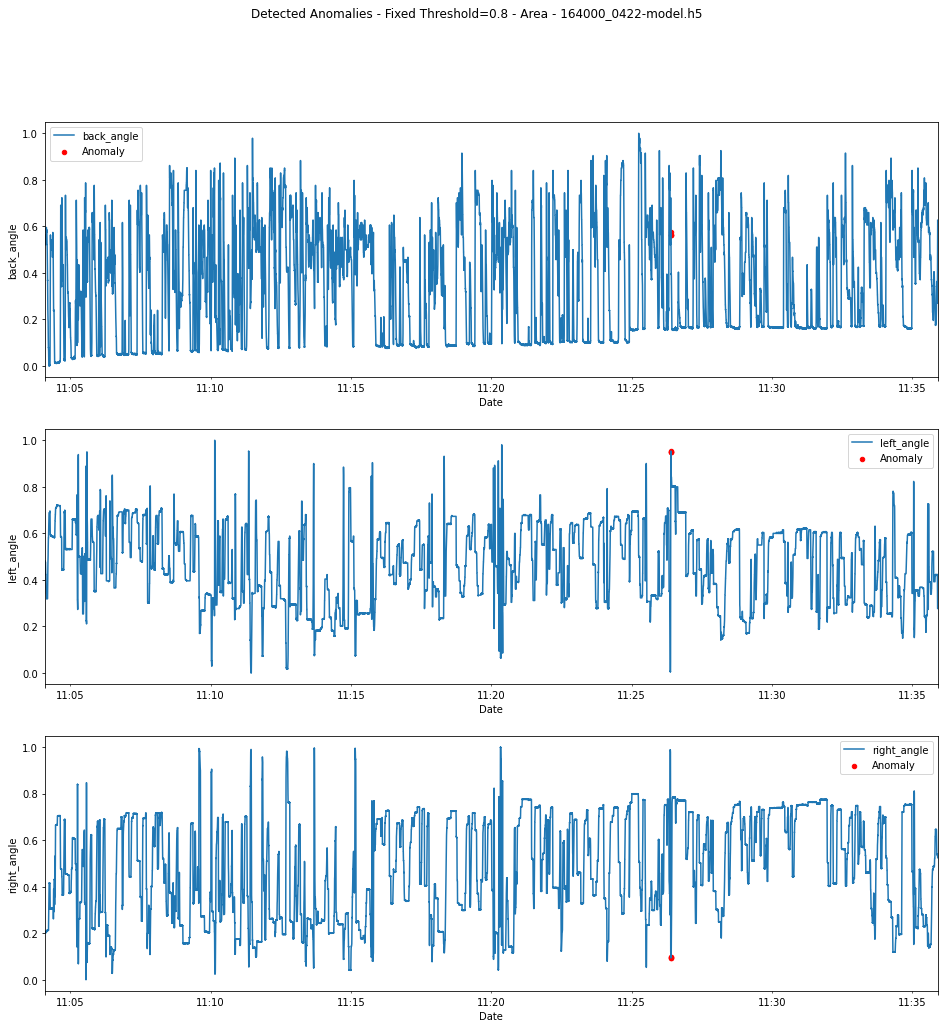

In [71]:
detect_anom_plot_and_save(no_feats, sensors, anomaly_frame, anomalies, pct, 'Area', backpat_model_file, DIAGRAM_FILE_PATH)